In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [106]:
data = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')

In [65]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [34]:
def plot_corr_heatmap(data, cmap="coolwarm"):
    # Only numeric columns are selected
    numeric_data = data.select_dtypes(include=["number"])
    sns.heatmap(numeric_data.corr(), center=0, cmap=cmap, linewidth=.5 )
    plt.show()

In [7]:
# Create "is_female" columns
# Missing age => relation between sex, parch, sibsp and class/fare?
# Remove PassengerId, Name, Ticket since they do not look like a good source of information
# Take a look at Cabin

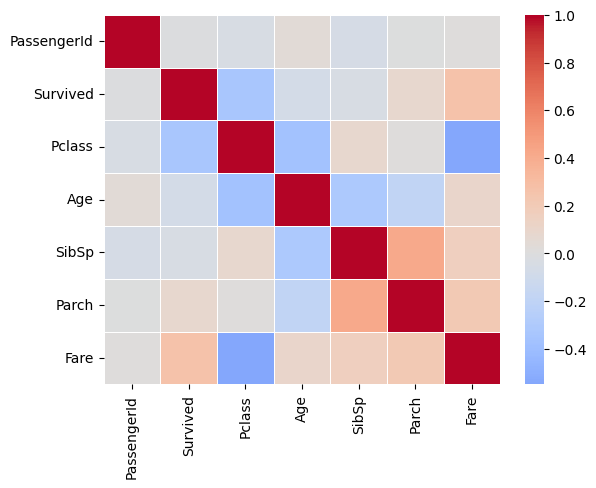

In [35]:
plot_corr_heatmap(data)
# Pclass and ticket fare have a noticed correlation, and a minor one between 
# sibligs/spouse and parent/children and age

In [36]:
data.info()
# Age has some null values, we'll try to stimated an average value considering the class, 
# sibligs/spouse and parent/children values
# The cabil value will be ignored 
# Embarked will be replace with a default value?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
# Quizas embarked se podría reemplazar por valores numericos y mirar si tienen alguna correlacion?
# Con ese dato quizas se podría ajustar ocn otros valores
# Como primera aproximación le pondremos un valor 

In [39]:
from sklearn.impute import KNNImputer

In [48]:
# Create KNN imputer
def age_imputer(data):
    knn_imputer = KNNImputer(n_neighbors=7)
    columns_to_impute = ["Age", "Pclass", "SibSp", "Parch"]
    
    data_imputed = pd.DataFrame(knn_imputer.fit_transform(data[columns_to_impute]), columns=columns_to_impute)
    
    #data_imputed.info()
    data[columns_to_impute]=data_imputed

In [56]:
def is_female_imputer(data):
    data['IsFemale']=data['Sex'].apply(lambda x: 0 if x == 'male' else (1 if x == 'female' else -1))

In [61]:
def embarked_encoder(data):
    data['C'] = data['Embarked'].apply(lambda x: 1 if x == 'C' else 0)
    data['S'] = data['Embarked'].apply(lambda x: 1 if x == 'S' else 0)
    data['Q'] = data['Embarked'].apply(lambda x: 1 if x == 'Q' else 0)
    data['N'] = data['Embarked'].apply(lambda x: 1 if x not in ['C', 'S', 'Q'] else 0)

In [93]:
def feature_dropper(data):
    data.drop(["PassengerId","Name","Sex","Ticket","Cabin","Embarked"], axis=1, inplace=True)

In [94]:
def imputer(data):
    age_imputer(data)
    is_female_imputer(data)
    embarked_encoder(data)
    feature_dropper(data)

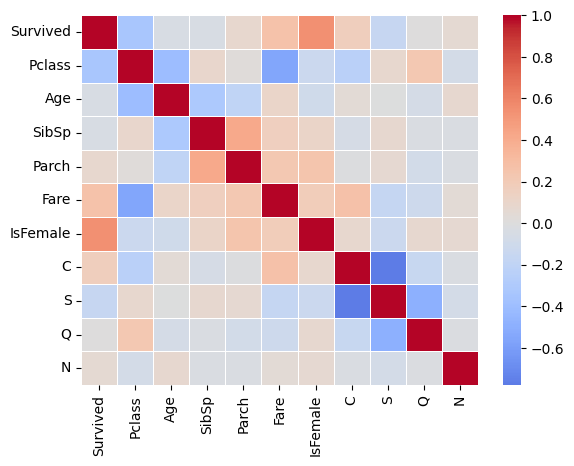

In [77]:
plot_corr_heatmap(data)

In [80]:
from sklearn.preprocessing import StandardScaler


In [81]:
X = data.drop(["Survived"], axis=1)
y = data["Survived"]

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier()

param_grid = [{
    "n_estimators": [10,100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split":[2,3,4]
}]

grid_search = GridSearchCV(rfc, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data, y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [91]:
final_rfc = grid_search.best_estimator_
final_rfc

RandomForestClassifier(max_depth=10, min_samples_split=3, n_estimators=200)

In [ ]:
#max_depth:10, min_samples_split:3, n_estimators:200
# probar a correrlo con un 75 por ciento y evaluar el 25 restante
# summitear los resultados

In [95]:
imputer(data_test)

In [99]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    float64
 1   Age       418 non-null    float64
 2   SibSp     418 non-null    float64
 3   Parch     418 non-null    float64
 4   Fare      417 non-null    float64
 5   IsFemale  418 non-null    int64  
 6   C         418 non-null    int64  
 7   S         418 non-null    int64  
 8   Q         418 non-null    int64  
 9   N         418 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 32.8 KB


In [100]:
X = data_test.fillna(method="ffill")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    float64
 1   Age       418 non-null    float64
 2   SibSp     418 non-null    float64
 3   Parch     418 non-null    float64
 4   Fare      418 non-null    float64
 5   IsFemale  418 non-null    int64  
 6   C         418 non-null    int64  
 7   S         418 non-null    int64  
 8   Q         418 non-null    int64  
 9   N         418 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 32.8 KB


/tmp/ipykernel_58490/3483389803.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = data_test.fillna(method="ffill")


In [101]:
scaler = StandardScaler()
X_data = scaler.fit_transform(X)

In [102]:
predictions = final_rfc.predict(X_data)

In [ ]:
# Ojo que aqui he sobreescrito el "data_Set" y no viene el pasesnger id...

In [107]:
final_df = pd.DataFrame(data_test["PassengerId"])
final_df['Survived']=predictions

In [108]:
final_df.to_csv("data/predictions.csv", index=False)

In [109]:
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
